In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Set seaborn style
sns.set(style="whitegrid")

sys.path.append(os.path.abspath(".."))
from src.data_preprocessing import *
from src.feature_engineering import *


In [74]:
df = load_merged_raw_data()

# Proposed Feature Engineering

## Transformation of TransactionDT

In [75]:
# Preview D9
print("D9 unique values:", df["D9"].dropna().unique())
# D9 is the fraction of the day

D9 unique values: [0.         0.041666   0.083333   0.125      0.166666   0.208333
 0.25       0.291666   0.33333299 0.416666   0.45833299 0.5
 0.54166597 0.58333302 0.625      0.66666597 0.70833302 0.75
 0.79166597 0.83333302 0.875      0.91666597 0.95833302 0.375     ]


In [76]:
df = transform_transaction_dt(df)

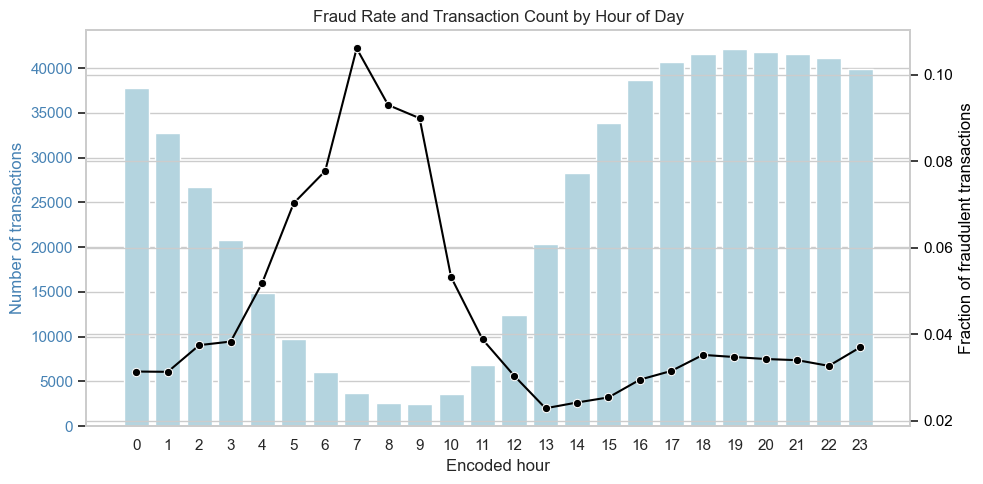

In [77]:
# Group by hour and calculate metrics
hourly_stats = df.groupby("hour").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot on left y-axis: Number of transactions
sns.barplot(x="hour", y="transaction_count", data=hourly_stats, color="lightblue", ax=ax1)
ax1.set_ylabel("Number of transactions", color="steelblue")
ax1.set_xlabel("Encoded hour")
ax1.tick_params(axis="y", labelcolor="steelblue")

# Create second y-axis for fraud rate
ax2 = ax1.twinx()
sns.lineplot(x="hour", y="fraud_rate", data=hourly_stats, color="black", marker="o", ax=ax2)
ax2.set_ylabel("Fraction of fraudulent transactions", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Fraud Rate and Transaction Count by Hour of Day")
plt.tight_layout()
plt.show()

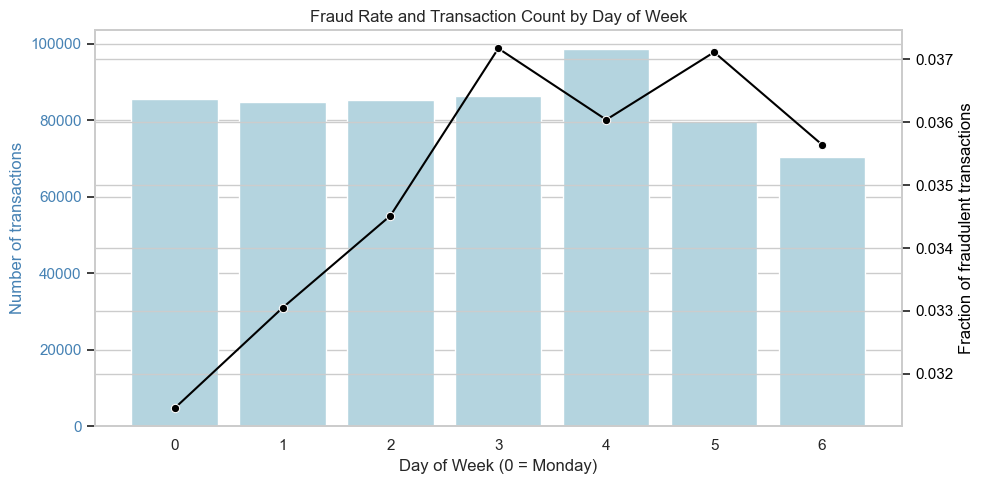

In [78]:
# Group by day of week
dow_stats = df.groupby("day_of_week").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.barplot(x="day_of_week", y="transaction_count", data=dow_stats, color="lightblue", ax=ax1)
ax1.set_ylabel("Number of transactions", color="steelblue")
ax1.set_xlabel("Day of Week (0 = Monday)")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
sns.lineplot(x="day_of_week", y="fraud_rate", data=dow_stats, color="black", marker="o", ax=ax2)
ax2.set_ylabel("Fraction of fraudulent transactions", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Fraud Rate and Transaction Count by Day of Week")
plt.tight_layout()
plt.show()


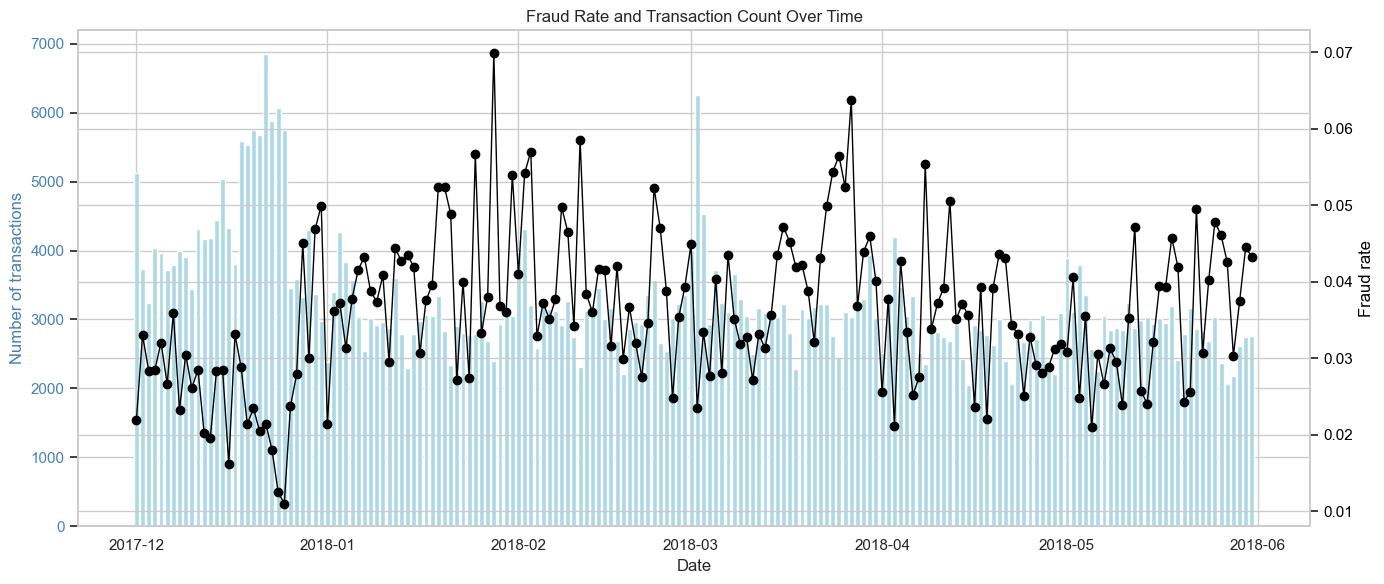

In [79]:
# Group by actual calendar date
daily_stats = df.groupby("date").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar for transaction count
ax1.bar(daily_stats["date"], daily_stats["transaction_count"], color="lightblue")
ax1.set_ylabel("Number of transactions", color="steelblue")
ax1.set_xlabel("Date")
ax1.tick_params(axis="y", labelcolor="steelblue")

# Line for fraud rate
ax2 = ax1.twinx()
ax2.plot(daily_stats["date"], daily_stats["fraud_rate"], color="black", marker="o", linewidth=1)
ax2.set_ylabel("Fraud rate", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Fraud Rate and Transaction Count Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Discussion of section

The chart above analyzes date-related features extracted from `TransactionDT`. It shows that the `hour` feature has the most significant impact in distinguishing fraud patterns. In contrast, features like `day_of_week` or `date` appear less informative on their own.

This is likely because:
- For `day_of_week`, the variation in fraud rate across different days is minimal, even though there are some sharp fluctuations in specific periods.
- For `date`, the trend is generally stable, making it less useful for the model.

Overall, `hour` captures more meaningful temporal patterns, which could improve model performance.

## Email Domains

In [80]:
df["P_emaildomain_group"] = df["P_emaildomain"].apply(map_email_provider)
df["R_emaildomain_group"] = df["R_emaildomain"].apply(map_email_provider)


### Sender domain

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/4256741405.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=domain_stats_p, x="transaction_count", y="P_emaildomain_group", ax=axes[0], palette="Blues_d")
/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/4256741405.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=domain_stats_p, x="fraud_rate", y="P_emaildomain_group", ax=axes[1], palette="Reds_d")


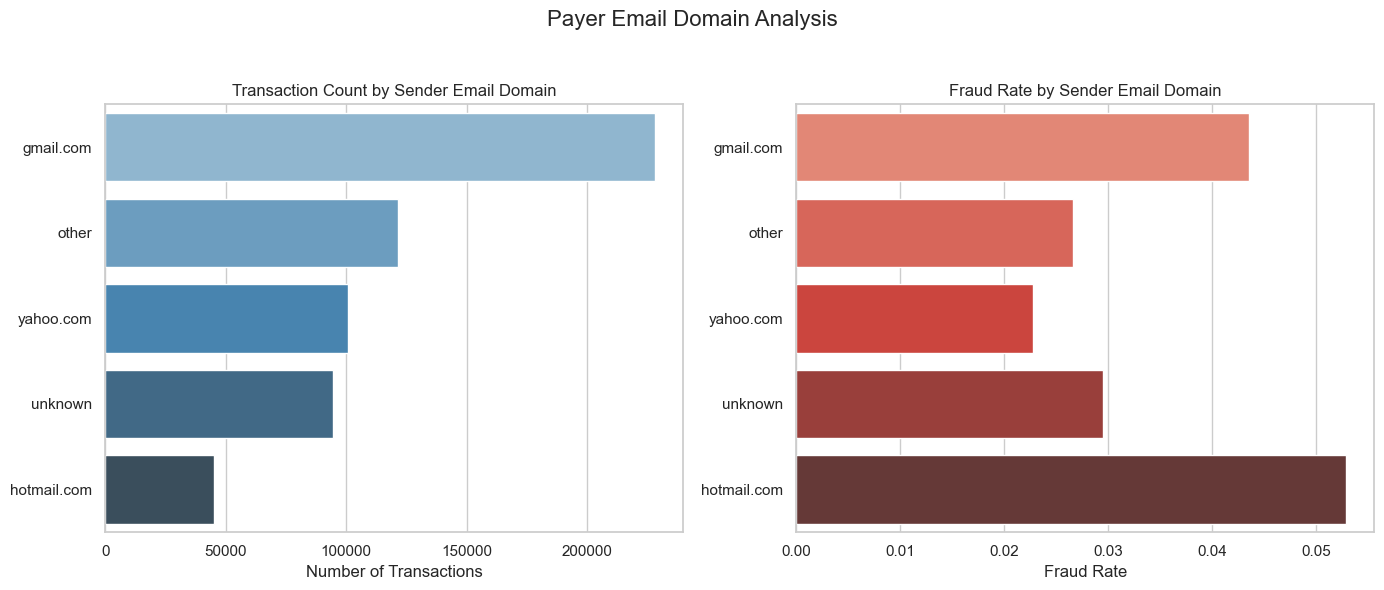

In [81]:

# Plot for P_emaildomain_group (payer)
domain_stats_p = df.groupby("P_emaildomain_group").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

domain_stats_p = domain_stats_p.sort_values(by="transaction_count", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=domain_stats_p, x="transaction_count", y="P_emaildomain_group", ax=axes[0], palette="Blues_d")
axes[0].set_title("Transaction Count by Sender Email Domain")
axes[0].set_xlabel("Number of Transactions")
axes[0].set_ylabel("")

sns.barplot(data=domain_stats_p, x="fraud_rate", y="P_emaildomain_group", ax=axes[1], palette="Reds_d")
axes[1].set_title("Fraud Rate by Sender Email Domain")
axes[1].set_xlabel("Fraud Rate")
axes[1].set_ylabel("")

plt.suptitle("Payer Email Domain Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Receiver domain

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/4093626597.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=domain_stats_r, x="transaction_count", y="R_emaildomain_group", ax=axes[0], palette="Blues_d")
/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/4093626597.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=domain_stats_r, x="fraud_rate", y="R_emaildomain_group", ax=axes[1], palette="Reds_d")


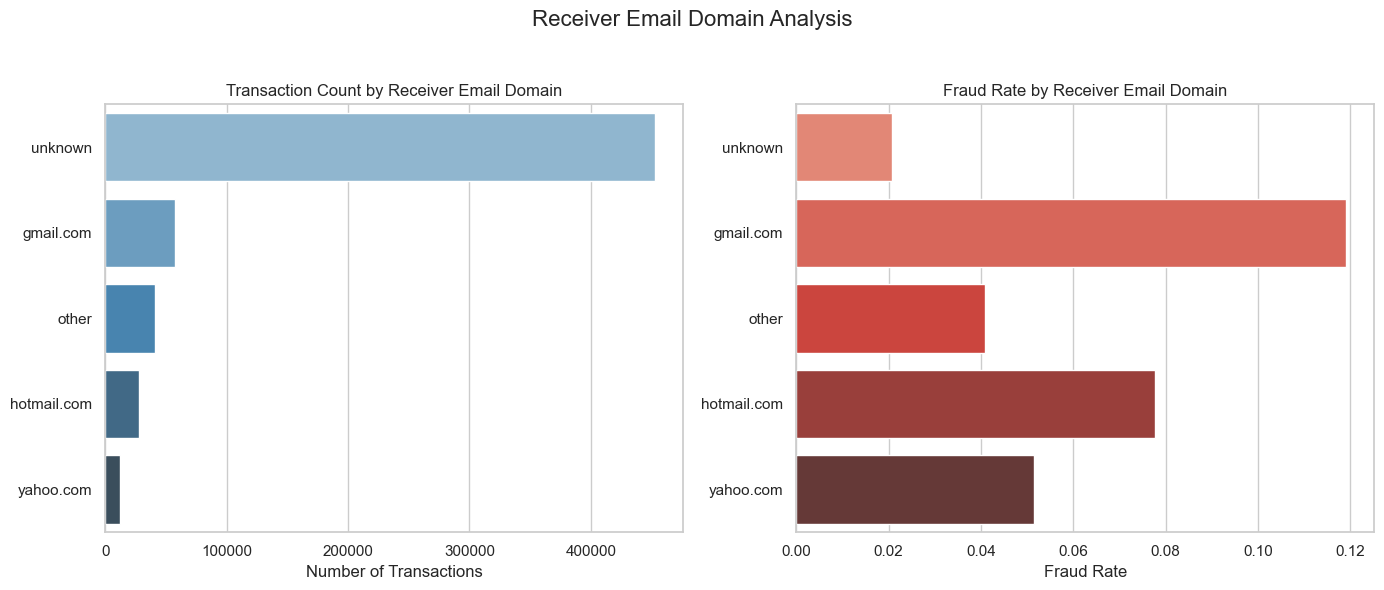

In [82]:
# Plot for R_emaildomain_group (receiver)
domain_stats_r = df.groupby("R_emaildomain_group").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

domain_stats_r = domain_stats_r.sort_values(by="transaction_count", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=domain_stats_r, x="transaction_count", y="R_emaildomain_group", ax=axes[0], palette="Blues_d")
axes[0].set_title("Transaction Count by Receiver Email Domain")
axes[0].set_xlabel("Number of Transactions")
axes[0].set_ylabel("")

sns.barplot(data=domain_stats_r, x="fraud_rate", y="R_emaildomain_group", ax=axes[1], palette="Reds_d")
axes[1].set_title("Fraud Rate by Receiver Email Domain")
axes[1].set_xlabel("Fraud Rate")
axes[1].set_ylabel("")

plt.suptitle("Receiver Email Domain Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Discussion of section

After grouping less common providers as `other`, we analyzed both sender (`P_emaildomain_group`) and receiver (`R_emaildomain_group`) domains to investigate their relation with fraud.

Sender Email Domains:

- While `gmail.com` has the **highest transaction volume**, `hotmail.com` and `unknown` domains show **noticeably higher fraud rates**.
- This suggests fraudsters may use **less common or disposable domains**, or attempt to mask email details.

Receiver Email Domains:

- The majority of transactions have `unknown` as the receiver domain, likely because many purchases don’t involve a recipient email.
- Among known domains, **`gmail.com` exhibits a higher fraud rate**, and again, `hotmail.com` and `yahoo.com` are riskier than average.

Conclusion:

- **Yes, the email provider can influence fraud risk**.
- Uncommon domains and missing values (`unknown`) appear differently in fraudulent transactions.
- These domain groupings can serve as useful **categorical features**

## Addresses and distances

In [83]:
# Check missingness
df[["addr1", "addr2", "dist1", "dist2"]].isnull().mean().sort_values(ascending=False)


dist2    0.936284
dist1    0.596524
addr2    0.111264
addr1    0.111264
dtype: float64

### Addresses

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/103979596.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="addr1", y="fraud_rate", data=addr1_stats, palette="coolwarm")


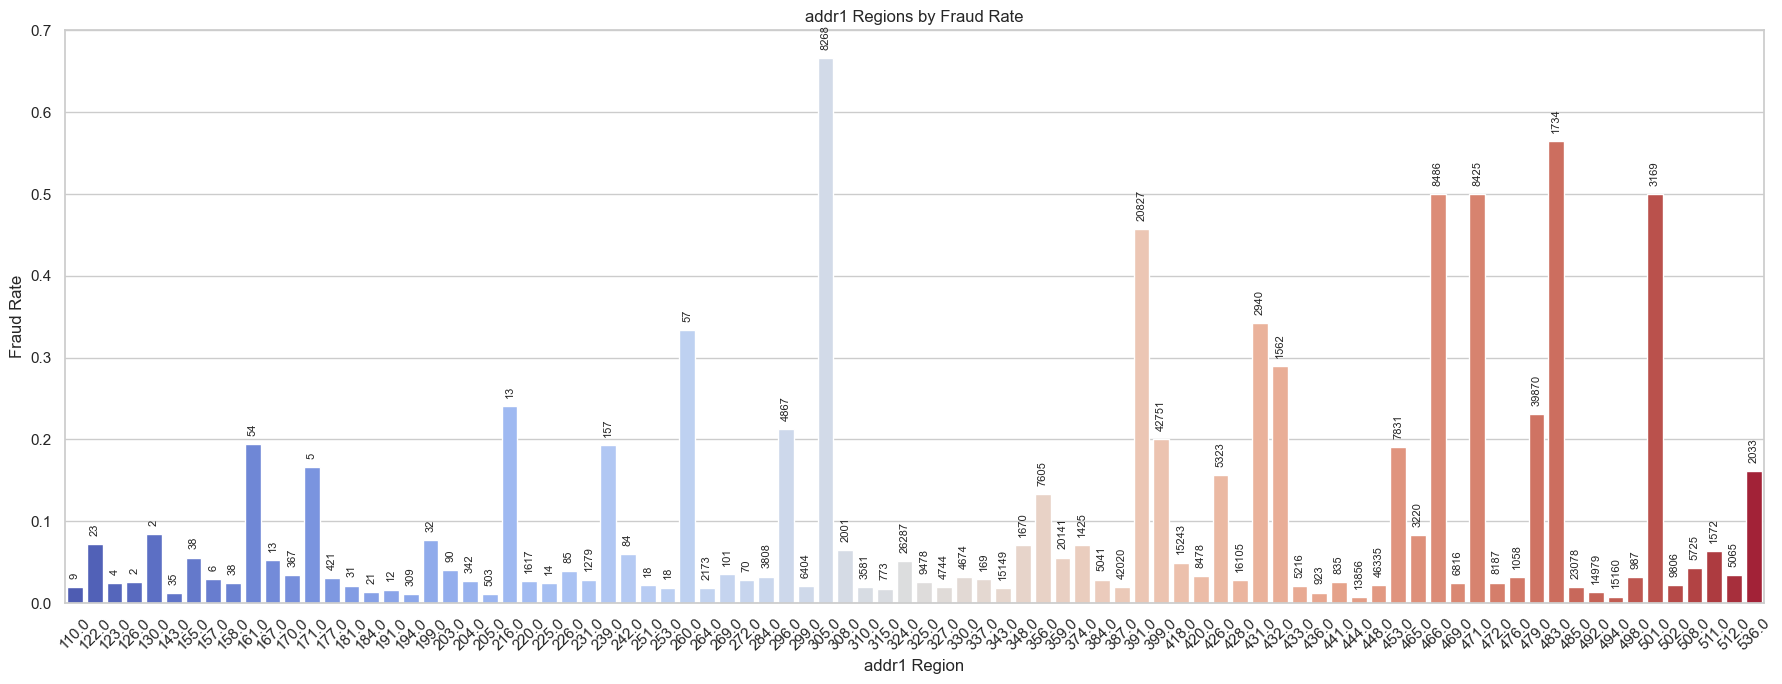

In [84]:
# Group and sort
addr1_stats = df.groupby("addr1").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

# Sort by fraud_rate or another metric
addr1_stats = addr1_stats.sort_values(by="fraud_rate", ascending=False)
addr1_stats = addr1_stats[addr1_stats["fraud_rate"] >= 0.001]  # remove small groups

plt.figure(figsize=(18, 7))
ax = sns.barplot(x="addr1", y="fraud_rate", data=addr1_stats, palette="coolwarm")

# Correct annotation placement using get_xticks
for bar, count in zip(ax.patches, addr1_stats["transaction_count"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 0.01, f'{int(count)}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.title("addr1 Regions by Fraud Rate")
plt.xlabel("addr1 Region")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/780707153.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="addr2", y="fraud_rate", data=addr2_stats, palette="coolwarm")


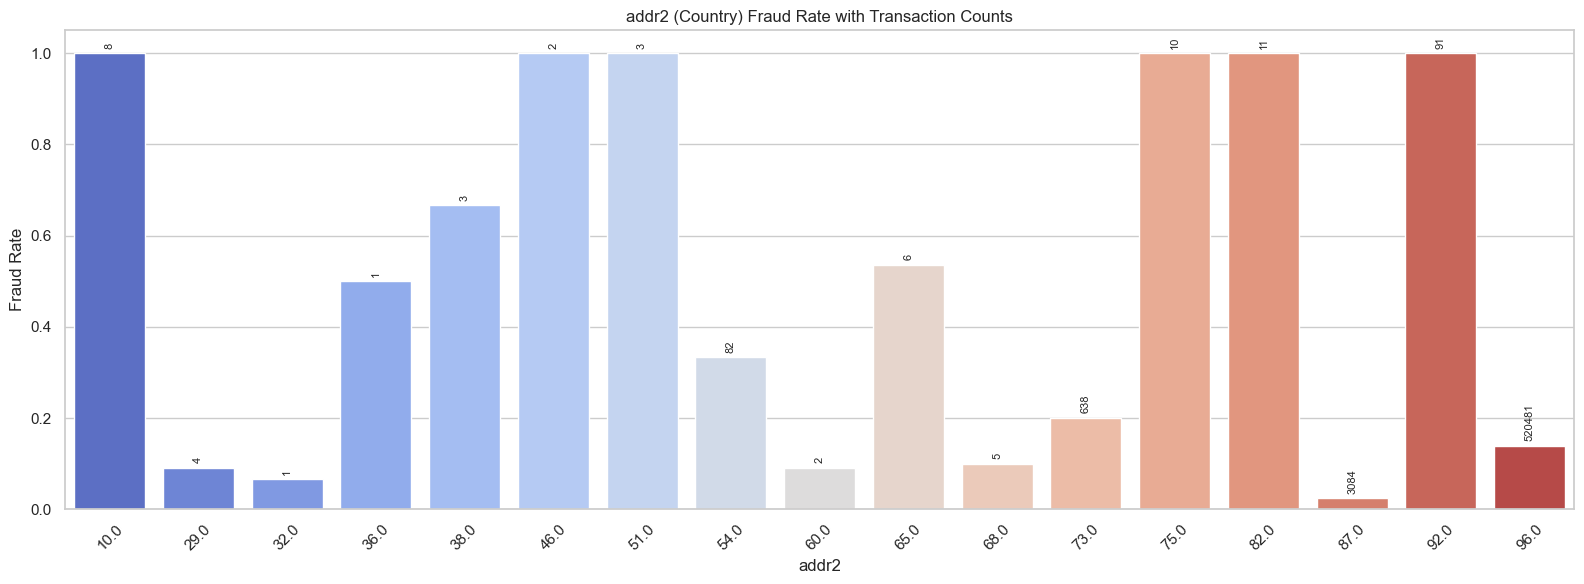

In [85]:
# Group and sort
addr2_stats = df.groupby("addr2").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

# Sort by fraud_rate or another metric
addr2_stats = addr2_stats.sort_values(by="fraud_rate", ascending=False)

addr2_stats = addr2_stats[addr2_stats["fraud_rate"] >= 0.0001]

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="addr2", y="fraud_rate", data=addr2_stats, palette="coolwarm")

# Correct annotation placement using get_xticks
for bar, count in zip(ax.patches, addr2_stats["transaction_count"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 0.01, f'{int(count)}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.title("addr2 (Country) Fraud Rate with Transaction Counts")
plt.xlabel("addr2")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Distances

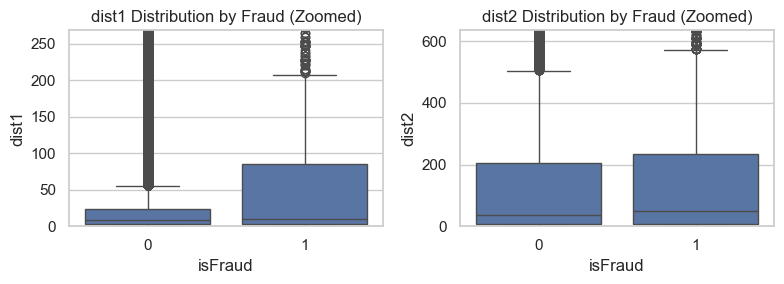

In [86]:
# Calculate the 90th percentile for each distance
dist1_cap = df["dist1"].dropna().quantile(0.9)
dist2_cap = df["dist2"].dropna().quantile(0.9)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Boxplot for dist1 (zoomed)
sns.boxplot(
    data=df,
    x="isFraud",
    y="dist1",
    ax=axs[0]
)
axs[0].set_title("dist1 Distribution by Fraud (Zoomed)")
axs[0].set_ylim(0, dist1_cap)
axs[0].set_xlabel("isFraud")
axs[0].set_ylabel("dist1")

# Boxplot for dist2 (zoomed)
sns.boxplot(
    data=df,
    x="isFraud",
    y="dist2",
    ax=axs[1]
)
axs[1].set_title("dist2 Distribution by Fraud (Zoomed)")
axs[1].set_ylim(0, dist2_cap)
axs[1].set_xlabel("isFraud")
axs[1].set_ylabel("dist2")

plt.tight_layout()
plt.show()

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/2859803597.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist1_stats = df.groupby("dist1_bin").agg(
/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/2859803597.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist2_stats = df.groupby("dist2_bin").agg(
/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/2859803597.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.

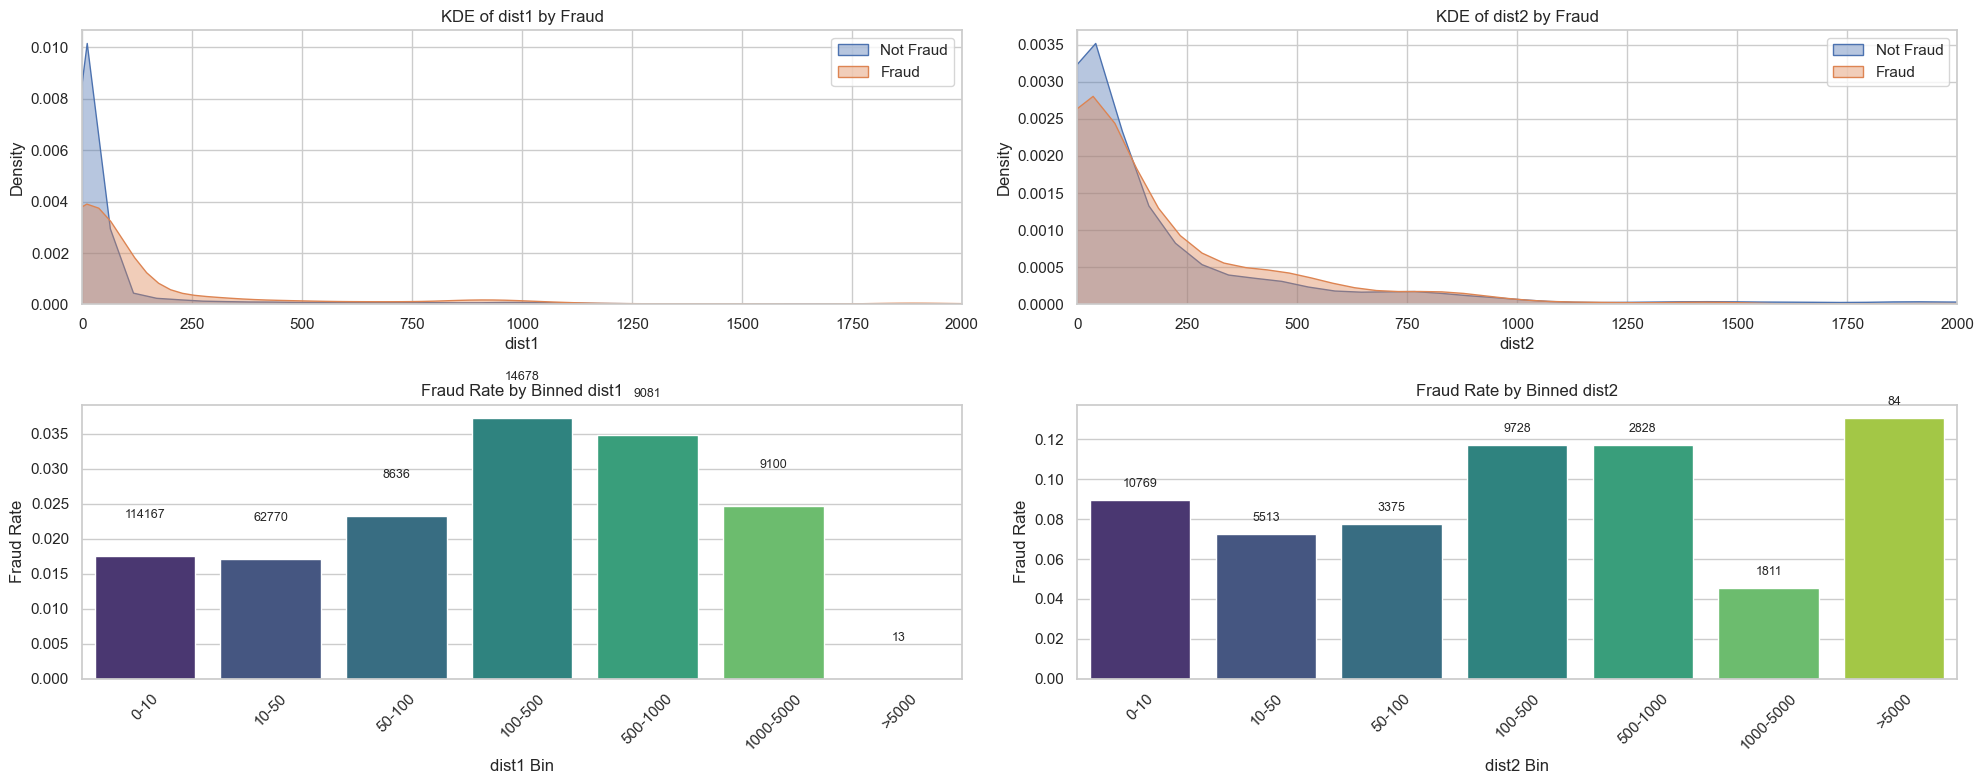

In [87]:
# Define bins and labels for distances
bins = [0, 10, 50, 100, 500, 1000, 5000, np.inf]
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '>5000']

# Create binned variables for dist1 and dist2
df["dist1_bin"] = pd.cut(df["dist1"], bins=bins, labels=labels)
df["dist2_bin"] = pd.cut(df["dist2"], bins=bins, labels=labels)

# Aggregate statistics for binned distances
dist1_stats = df.groupby("dist1_bin").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

dist2_stats = df.groupby("dist2_bin").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

# Top left: KDE plot for dist1
sns.kdeplot(df[df["isFraud"]==0]["dist1"], label="Not Fraud", fill=True, alpha=0.4, ax=axs[0,0])
sns.kdeplot(df[df["isFraud"]==1]["dist1"], label="Fraud", fill=True, alpha=0.4, ax=axs[0,0])
axs[0,0].set_title("KDE of dist1 by Fraud")
axs[0,0].set_xlim(0, 2000)
axs[0,0].set_xlabel("dist1")
axs[0,0].legend()

# Top right: KDE plot for dist2
sns.kdeplot(df[df["isFraud"]==0]["dist2"], label="Not Fraud", fill=True, alpha=0.4, ax=axs[0,1])
sns.kdeplot(df[df["isFraud"]==1]["dist2"], label="Fraud", fill=True, alpha=0.4, ax=axs[0,1])
axs[0,1].set_title("KDE of dist2 by Fraud")
axs[0,1].set_xlim(0, 2000)
axs[0,1].set_xlabel("dist2")
axs[0,1].legend()

# Bottom left: Bar plot for binned dist1 with fraud rate and transaction counts
sns.barplot(x="dist1_bin", y="fraud_rate", data=dist1_stats, palette="viridis", ax=axs[1,0])
axs[1,0].set_title("Fraud Rate by Binned dist1")
axs[1,0].set_xlabel("dist1 Bin")
axs[1,0].set_ylabel("Fraud Rate")
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45)
# Annotate transaction counts on each bar
for i, row in dist1_stats.iterrows():
    axs[1,0].text(i, row["fraud_rate"] + 0.005, f'{int(row["transaction_count"])}',
                  ha='center', va='bottom', fontsize=9)

# Bottom right: Bar plot for binned dist2 with fraud rate and transaction counts
sns.barplot(x="dist2_bin", y="fraud_rate", data=dist2_stats, palette="viridis", ax=axs[1,1])
axs[1,1].set_title("Fraud Rate by Binned dist2")
axs[1,1].set_xlabel("dist2 Bin")
axs[1,1].set_ylabel("Fraud Rate")
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45)
# Annotate transaction counts on each bar
for i, row in dist2_stats.iterrows():
    axs[1,1].text(i, row["fraud_rate"] + 0.005, f'{int(row["transaction_count"])}',
                  ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Discussion of section

In this section, we investigated how geographic and distance-related features might affect transaction behavior and potentially signal fraud risk.

- **Addresses (addr1 & addr2):**  
  We analyzed the categorical variables `addr1` (regional indicator) and `addr2` (typically a country-level code).  
  - **Findings:**  
    - While some address groups show varying fraud rates, many groups have a low number of transactions, which can distort the overall picture.  
    - Filtering can help in highlighting the more reliable patterns. We achieved better visualizations with filtering by fraud rate and see there are some very high fraud rates which has very little transactions. However, when filtering by transaction count, fewer address types emerge as having significant fraud rates. So it is the decision of building the model how to use them.

- **Distances (dist1 & dist2):**  
  We explored the numerical distance features using multiple visualizations:
  - **KDE Plots:**  
    - Revealed the density distributions of `dist1` and `dist2` for fraudulent and non-fraudulent transactions.  
    - The majority of transactions cluster within a certain range, with subtle shifts in density between the two groups.
  - **Binned Bar Plots:**  
    - Grouping distances into defined intervals allowed us to observe trends in fraud rate across different distance ranges.  
    - Transaction counts were annotated to highlight bins with sufficient data.
  - **Zoomed Box Plots:**  
    - By focusing on the 90th percentile, these plots exposed the main cluster of values, making it easier to distinguish normal behavior from potential anomalies.
  - **Missing Values:**  
    - A high percentage of missing values in these features might itself be informative, suggesting that a “missing” flag could be a valuable addition in the modeling process.

**Conclusion:**  
The analysis indicates that both address groupings and distance measures exhibit patterns that could influence the type or value of a transaction. Although the effects are subtle, these features are promising for further feature engineering and could enhance the predictive power of a fraud detection model.

## Binary variables M1, M2, M3...

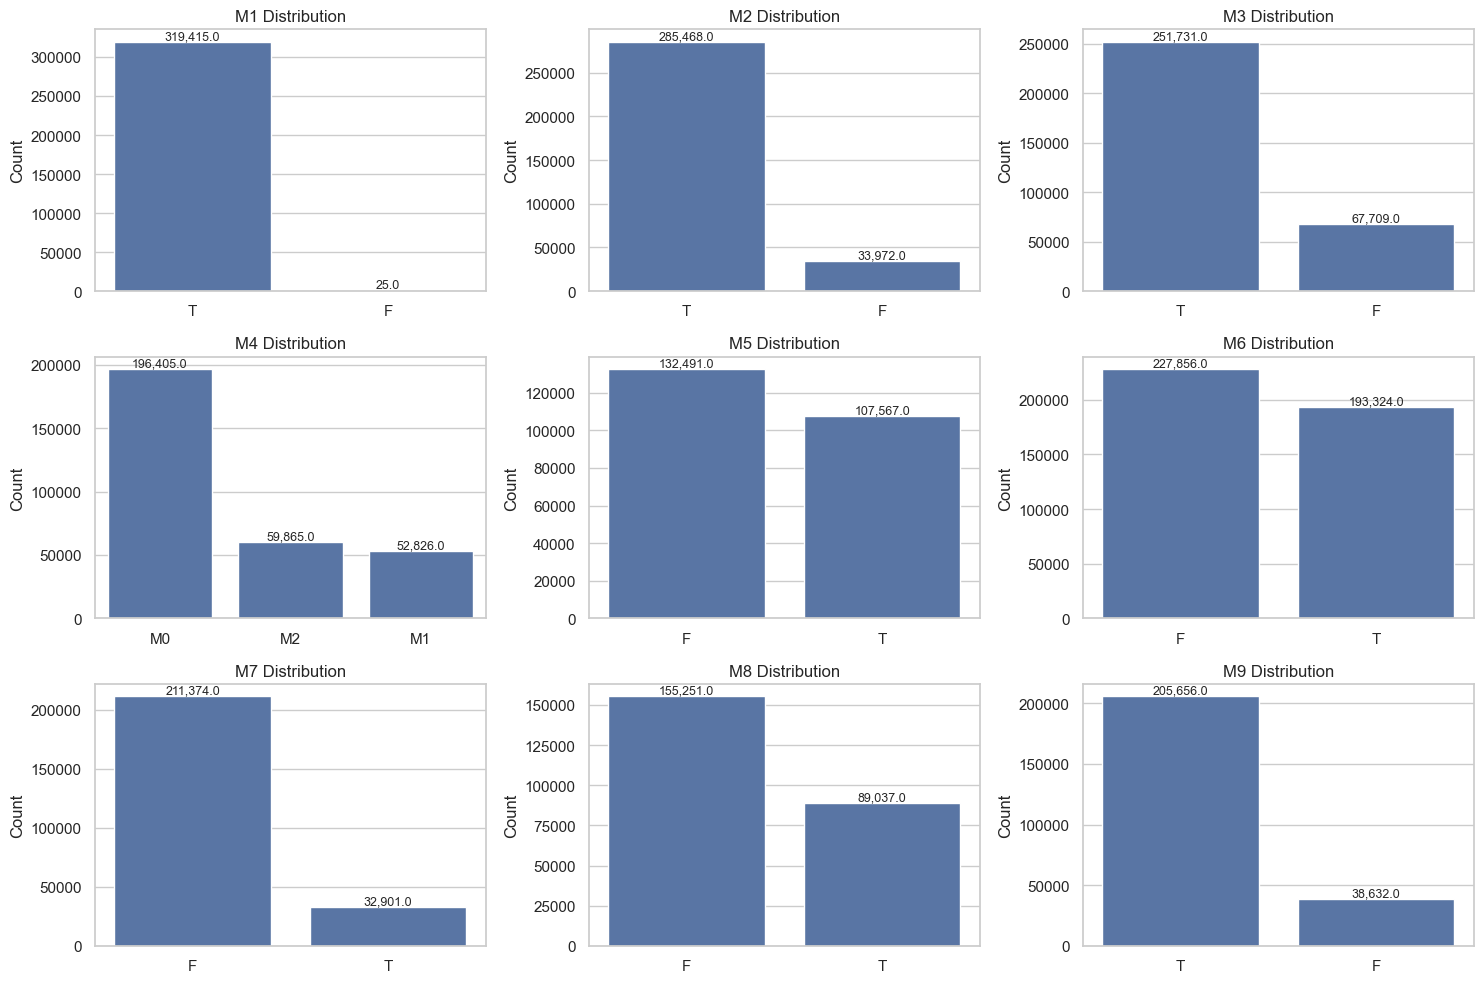

In [88]:
# List of M columns
m_cols = [col for col in df.columns if col.startswith("M")]

# Check unique values and plot distribution of each M column
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(m_cols):
    sns.countplot(x=col, data=df, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{height:,}', (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_47148/3567477771.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=m_count_stats, x="M_true_count", y="fraud_rate", palette="coolwarm")


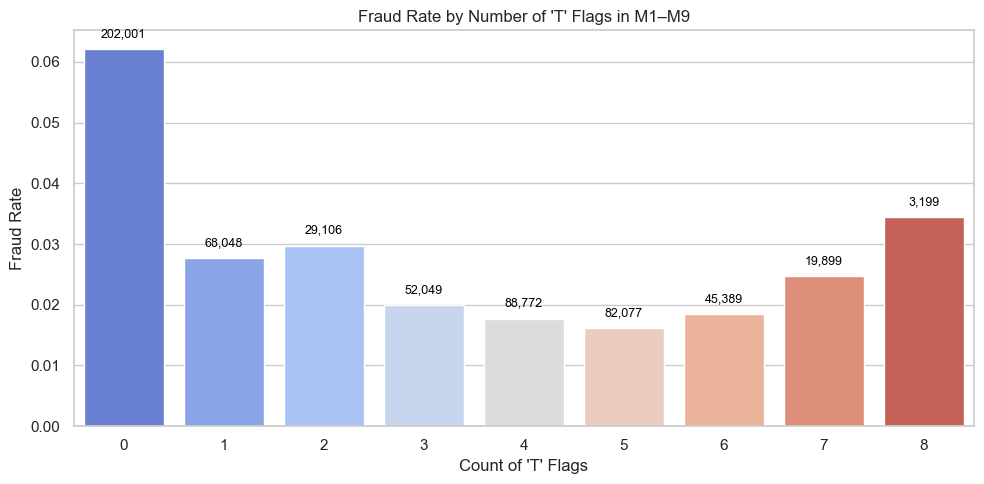

In [89]:
# Create an aggregated variable: count of 'T' per row
df["M_true_count"] = df[m_cols].apply(lambda row: sum(row == 'T'), axis=1)

# Plot fraud rate by M_true_count
m_count_stats = df.groupby("M_true_count").agg(
    transaction_count=("isFraud", "count"),
    fraud_rate=("isFraud", "mean")
).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=m_count_stats, x="M_true_count", y="fraud_rate", palette="coolwarm")
plt.title("Fraud Rate by Number of 'T' Flags in M1–M9")
plt.xlabel("Count of 'T' Flags")
plt.ylabel("Fraud Rate")
for index, row in m_count_stats.iterrows():
    plt.text(index, row.fraud_rate + 0.002, f'{int(row.transaction_count):,}', 
             color='black', ha="center", fontsize=9)
plt.tight_layout()
plt.show()


### Discussion of section

In our analysis of the M-variables, we observed the following:

- **Individual Distributions:**  
  Most M-variables (M1, M2, M3, M5, M6, etc.) are binary with values 'T' (True) or 'F' (False). However, **M4 stands out**—it shows multiple values (e.g., 'M0', 'M1', 'M2') rather than a simple boolean. This suggests that M4 represents a multi-class categorical flag and should be encoded differently (e.g., one-hot encoding) rather than combined with the other binary flags.

- **Aggregated Signal – Count of 'T' Flags:**  
  Excluding M4, we aggregated the other flags into a feature (`M_true_count`), which counts how many of these M-variables are 'T' for each transaction.  
  - Our analysis of this aggregated feature revealed that transactions with **0 'T' flags** have a relatively high fraud rate.
  - As the count increases, the fraud rate initially decreases, indicating that some level of system flag activation may be protective.
  - Interestingly, when almost all flags are 'T', there is a slight uptick in fraud rate, suggesting a complex relationship.

**Conclusion:**  
The aggregated count of 'T' flags appears to be a promising feature for fraud detection. At the same time, M4’s distinct behavior indicates that it should be treated as a separate categorical variable. These insights can guide further feature engineering and model development.